In [134]:
from datetime import datetime
import pandas as pd
import seaborn as sns

In [148]:
classification_df = pd.read_csv('demand_classification_by_item.csv', sep=';')
raw_df = pd.read_csv('df_periodos_rellenados.csv', sep=';')
display(raw_df)
display(classification_df)

,time,item,sales
0,2019-06-24,1002,24
1,2020-08-31,1002,224
2,2021-02-08,1002,40
3,2021-03-22,1002,80
4,2021-03-29,1002,16
...,...,...,...
3338696,2023-11-22,9998,0
3338697,2023-11-23,9998,0
3338698,2023-11-24,9998,0
3338699,2023-11-25,9998,0


,item,p,cv2,demand_type
0,1002,128.071429,0.612206,lumpy
1,1003,234.000000,0.213018,intermittent
2,1006,84.652174,4.362716,lumpy
3,1007,1.000000,0.000000,smooth
4,1009,1.000000,0.000000,smooth
...,...,...,...,...
3812,9988,312.000000,0.000000,intermittent
3813,9989,1.000000,0.000000,smooth
3814,9994,150.000000,0.291320,intermittent
3815,9997,1.000000,0.000000,smooth


In [149]:
raw_df['time'] = pd.to_datetime(raw_df['time'], format="%Y-%m-%d")
raw_df['time'] = raw_df.time.dt.to_period('M').dt.to_timestamp()
raw_df

,time,item,sales
0,2019-06-01,1002,24
1,2020-08-01,1002,224
2,2021-02-01,1002,40
3,2021-03-01,1002,80
4,2021-03-01,1002,16
...,...,...,...
3338696,2023-11-01,9998,0
3338697,2023-11-01,9998,0
3338698,2023-11-01,9998,0
3338699,2023-11-01,9998,0


### Solo consideramos los ítems de demanda Lumpy e Intermittent

In [150]:
intermittent_ids = classification_df[classification_df.demand_type == 'intermittent']['item'].unique()
lumpy_ids = classification_df[classification_df.demand_type == 'lumpy']['item'].unique()
df = raw_df[(raw_df['item'].isin(intermittent_ids)) | (raw_df['item'].isin(lumpy_ids))]
df

,time,item,sales
0,2019-06-01,1002,24
1,2020-08-01,1002,224
2,2021-02-01,1002,40
3,2021-03-01,1002,80
4,2021-03-01,1002,16
...,...,...,...
3338696,2023-11-01,9998,0
3338697,2023-11-01,9998,0
3338698,2023-11-01,9998,0
3338699,2023-11-01,9998,0


### Dividimos en set de entrenamiento, test y validación

In [151]:
# Import necessary libraries
import numpy as np
import pandas as pd
from darts import TimeSeries
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.stats.diagnostic import acorr_ljungbox
import pmdarima as pm
from darts.models import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [152]:
filtered_df = df[df.item == 5432]
filtered_df

,time,item,sales
21056,2018-08-01,5432,1
21057,2018-09-01,5432,30
21058,2018-10-01,5432,30
21059,2018-10-01,5432,70
21060,2018-11-01,5432,14
...,...,...,...
1657064,2024-09-01,5432,0
1657065,2024-09-01,5432,0
1657066,2024-09-01,5432,0
1657067,2024-09-01,5432,0


In [153]:
train_df = filtered_df[filtered_df['time'] < datetime(2024, 1, 1)]
test_df = filtered_df[filtered_df['time'] >= datetime(2024, 1, 1)]

train_df = train_df.set_index('time')[['sales']]
test_df = test_df.set_index('time')[['sales']]

In [154]:
train_df

,sales
time,
2018-08-01,1
2018-09-01,30
2018-10-01,30
2018-10-01,70
2018-11-01,14
...,...
2023-12-01,0
2023-12-01,0
2023-12-01,0


In [155]:
model_autoarima = pm.auto_arima(train_df,
                     start_p=1,
                     start_q=1,
                     test='adf',
                     m=12,
                     seasonal=True,
                     trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=12893.136, Time=2.05 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=14091.978, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=13315.198, Time=0.59 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=13414.245, Time=1.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=14122.487, Time=0.01 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=12891.144, Time=2.60 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=13005.263, Time=0.31 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=12893.131, Time=4.81 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=12904.833, Time=2.24 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=12867.554, Time=9.33 sec
 ARIMA(1,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=7.85 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=12888.351, Time=5.32 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=13293.797, Time=3.78 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=13291.353, Time=4.13 sec
 ARIMA(2,0,

In [156]:
model_sarimax = SARIMAX(endog = train_df, order = (1, 0 ,3), seasonal_order = (1, 0, 2, 12))
modelo_res = model_sarimax.fit(disp=0)

In [157]:
predictions_statsmodels = modelo_res.get_forecast(steps=len(test_df)).predicted_mean.reset_index()['predicted_mean']
predictions_statsmodels

0      8.440775e-27
1     -9.580712e-27
2      7.841800e-28
3     -9.428040e-27
4      3.608145e-27
           ...     
262   -1.276073e-28
263   -2.522144e-27
264    1.472854e-27
265    2.613281e-28
266    3.417896e-28
Name: predicted_mean, Length: 267, dtype: float64

In [158]:
predictions_statsmodels.index = test_df.index
predictions_statsmodels

time
2024-01-01    8.440775e-27
2024-02-01   -9.580712e-27
2024-03-01    7.841800e-28
2024-05-01   -9.428040e-27
2024-08-01    3.608145e-27
                  ...     
2024-09-01   -1.276073e-28
2024-09-01   -2.522144e-27
2024-09-01    1.472854e-27
2024-09-01    2.613281e-28
2024-09-01    3.417896e-28
Name: predicted_mean, Length: 267, dtype: float64

In [160]:
len(test_df)

267

In [161]:
len(predictions_statsmodels)

267

In [162]:
test_df

,sales
time,
2024-01-01,20
2024-02-01,90
2024-03-01,10
2024-05-01,15
2024-08-01,30
...,...
2024-09-01,0
2024-09-01,0
2024-09-01,0


In [163]:
predictions_statsmodels

time
2024-01-01    8.440775e-27
2024-02-01   -9.580712e-27
2024-03-01    7.841800e-28
2024-05-01   -9.428040e-27
2024-08-01    3.608145e-27
                  ...     
2024-09-01   -1.276073e-28
2024-09-01   -2.522144e-27
2024-09-01    1.472854e-27
2024-09-01    2.613281e-28
2024-09-01    3.417896e-28
Name: predicted_mean, Length: 267, dtype: float64

In [164]:
test_df['predicted'] = predictions_statsmodels
test_df.head(20)

,sales,predicted
time,,
2024-01-01,20,8.440775e-27
2024-02-01,90,-9.580712e-27
2024-03-01,10,7.841800e-28
2024-05-01,15,-9.428040e-27
2024-08-01,30,3.608145e-27
2024-09-01,50,-2.268788e-26
2024-09-01,15,-1.625008e-26
2024-01-01,0,1.358981e-26
2024-01-01,0,-3.160536e-27


In [165]:
melt_df = pd.melt(test_df.reset_index(), ['time'])
melt_df

,time,variable,value
0,2024-01-01,sales,2.000000e+01
1,2024-02-01,sales,9.000000e+01
2,2024-03-01,sales,1.000000e+01
3,2024-05-01,sales,1.500000e+01
4,2024-08-01,sales,3.000000e+01
...,...,...,...
529,2024-09-01,predicted,-1.276073e-28
530,2024-09-01,predicted,-2.522144e-27
531,2024-09-01,predicted,1.472854e-27
532,2024-09-01,predicted,2.613281e-28


<Axes: xlabel='time'>

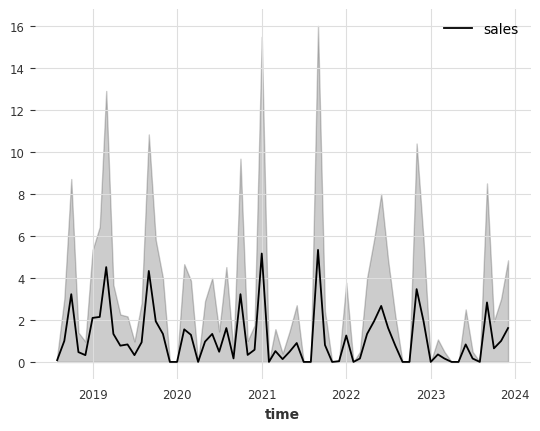

In [166]:
sns.lineplot(train_df)

<Axes: xlabel='time'>

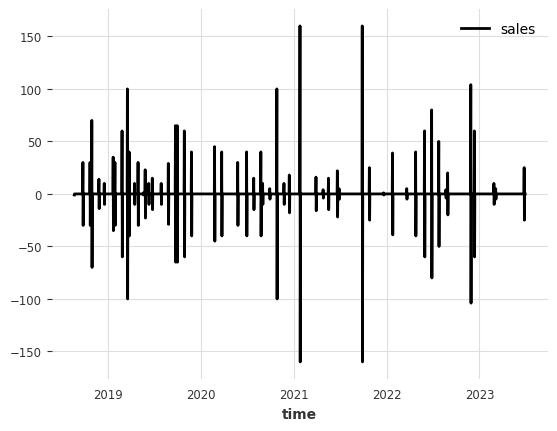

In [144]:
train_serie.diff().plot()